# Experiment to Solve the forward problem of converting a graph to dynamics - Model B

In [1]:
from episodic_memory.utils.all_imports import *
from decouple import config # obtain environment files

from bokeh.io import export_svg

import argparse
import os
import numpy as np
# sys.path.append('/media/arjun/Shared/research_projects/episodic_hopfield/python_modules')

from episodic_memory.experiment import temporal_pattern_from_output, find_best_chain_length, pattern_changes_from_temporal_pattern
from episodic_memory.experiment import train_episodic_network
from episodic_memory.utils import normalize
from episodic_memory.networks.AdiabaticEpisodicExp import AdiabaticEpisodicExponential
from bokeh.models import Range1d

from episodic_memory.plotting import quick_plot
from tqdm.notebook import tqdm

from sklearn.decomposition import PCA

COLORS = ["red", "olive", "darkred", "goldenrod", "skyblue", "orange", "salmon"]

output_notebook()

%load_ext autoreload
%autoreload 2

Loading BokehJS ...

In [2]:
COLORS = list(all_palettes['Dark2'][8])

In [3]:
COLORS

['#1b9e77',
 '#d95f02',
 '#7570b3',
 '#e7298a',
 '#66a61e',
 '#e6ab02',
 '#a6761d',
 '#666666']

In [4]:
# N = 100
# SEED = 0
# N_PATTERNS = 7
# T_d = 100
# ALPHA_S = 1.0
# ALPHA_C = 0.7

N = 100
SEED = 0
N_PATTERNS = 7
T_d = 20
ALPHA_S = 1.0
ALPHA_C = 4.9

# Experiment Setup

In [5]:
# create and initialize network and memories
mnet = AdiabaticEpisodicExponential()
mnet.initialize(seed=SEED,
                T_d=T_d,
                alpha_s = ALPHA_S,
                alpha_c = ALPHA_C,
                N=N,
                n_patterns=N_PATTERNS,
                approximation="range-kutta")

np.random.seed(SEED)

# create patterns
n_patterns = N_PATTERNS
patterns = mnet.xi.T

## Convert graph to activation

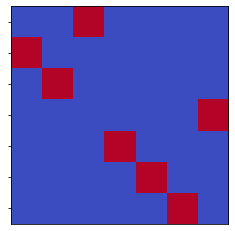

In [6]:
xi = np.array(patterns).T

G = np.array([
    [ 0, 1, 0, 0, 0, 0, 0 ],
    [ 0, 0, 1, 0, 0, 0, 0 ],
    [ 1, 0, 0, 0, 0, 0, 0 ],
    [ 0, 0, 0, 0, 1, 0, 0 ],
    [ 0, 0, 0, 0, 0, 1, 0 ],
    [ 0, 0, 0, 0, 0, 0, 1 ],
    [ 0, 0, 0, 1, 0, 0, 0 ],
])

mnet.phi = G.T

ax = plt.axes()
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off

plt.imshow(mnet.phi, cmap="coolwarm")
plt.show()
# plt.savefig("/media/arjun/Shared/tmp/tanh_episodic.png")

In [7]:
cue = xi[:, 4].astype('float')
cue[-int(0.25*N):]=0

print(cue)

[ 1. -1. -1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1. -1. -1. -1.  1.  1.
 -1. -1.  1. -1. -1.  1.  1. -1. -1.  1.  1. -1. -1. -1.  1.  1. -1. -1.
  1. -1.  1. -1. -1.  1.  1.  1. -1.  1. -1.  1. -1. -1. -1.  1.  1.  1.
  1.  1.  1. -1.  1. -1.  1.  1.  1.  1. -1. -1.  1.  1. -1. -1.  1.  1.
 -1. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [8]:
# test network
mnet_test = copy.deepcopy(mnet)
simulated = []
energy_trajectory = []

cue = xi[:, 4].astype('float')
cue[-int(0.25*N):]=0
# cue[5:, :] = 0

mnet_test.v = cue.flatten()

# simulated.append((mnet_test.g(mnet_test.v).copy(), mnet_test.get_energy(), mnet_test.v.copy()))

diag_freq = 10

for i in tqdm(range(int(5*n_patterns*10000)//6)):
    mnet_test.update()
    
    if i < 100:
        per = diag_freq
    else:
        per = diag_freq
        
    if i % per == 0:
        simulated.append((mnet_test.g(mnet_test.v).copy(), mnet_test.get_energy(), mnet_test.v.copy(), mnet_test.v_d.copy(), 
                          np.linalg.norm(mnet_test.func_v_d(mnet_test.v_d))))
        # energy_trajectory.append(get_energy(mnet_test))
        # for pattern_idx, pattern in enumerate(patterns):
        #     memory_energy_trajectories[pattern_idx].append(get_energy_at_state(mnet_test, pattern))

  0%|          | 0/58333 [00:00<?, ?it/s]

In [9]:
np.mean(np.abs([ var[2] for var in simulated[100:101] ] ))

0.9917382761206224

In [10]:
pattern_correlations_test =  np.array([var[0] for var in simulated[:6000]]) @ xi / N
                                  
fig=None
 
legend_it = []

plot_options = dict(width=800,
                    plot_height=350,
                    tools="pan,reset,save,xwheel_zoom")

fig = figure(**plot_options)

# for pattern_id in range(min(len(COLORS), len(patterns))):
for pattern_id in range(len(patterns)):
    fig, line_glyph = quick_plot.plot_line(np.array(range(0, diag_freq*pattern_correlations_test.shape[0], diag_freq))/1e3,
                                pattern_correlations_test[:, pattern_id],
                                tools=["xwheel_zoom"],
                                fig=fig,
                                line_width=4,
                                # legend_label="memory: {}".format(pattern_id + 1),
                                color=COLORS[pattern_id % len(COLORS)])
    legend_it.append(("memory: {}".format(pattern_id + 1), [ line_glyph ]))
    # fig = quick_plot.plot_line(normalize([ var[1] for var in simulated ]),
    #                            tools=["xwheel_zoom"],
    #                            fig=fig,
    #                            legend_label="energy",
    #                            color="black")

legend = Legend(items=legend_it)
legend.click_policy="hide"

fig.xgrid.grid_line_color = None
fig.ygrid.grid_line_color = None
# fig.xaxis.axis_label = 'whatever'
fig.xaxis.major_label_text_font_size = "15pt"
fig.yaxis.major_label_text_font_size = "15pt"
fig.yaxis[0].ticker.desired_num_ticks = 6
fig.xaxis[0].ticker.desired_num_ticks = 5

fig.add_layout(legend, "right")
fig.output_backend = "svg"

show(fig)

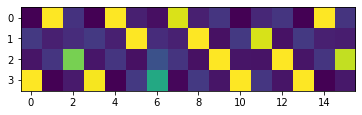

In [11]:
plt.imshow(mnet.f(pattern_correlations_test[1200:3500:150])[:, 3:].T)
plt.savefig("time_cell_B.png")
plt.show()

In [12]:
fig.output_backend = "svg"

## Get the nearest fixed point from the current state

In [13]:
# max_eigvals = []
# jac_norms = []
# memory_state_jacs = []
# memory_state_hess = []

# for var in tqdm(simulated):
#     # memory_state_jacs.append([ np.linalg.norm(mnet_test.get_energy_jacobian_v(xi[:, i], var[3])) 
#     #                           for i in range(N_PATTERNS) ])
#     # memory_state_hess.append([ np.min(np.linalg.eig(mnet_test.get_energy_hessian_v(xi[:, i], var[3]))[0].real) 
#     #                           for i in range(N_PATTERNS) ])
    
#     # jac_norms.append(np.linalg.norm(mnet_test.get_energy_jacobian_v(var[2], var[3])))
#     max_eigvals.append(np.min(np.linalg.eig(mnet_test.get_energy_hessian_v(var[2], var[3]))[0].real))

In [14]:
## Find fixed points
from scipy import optimize

memory_fixed_points = []

for var in tqdm(simulated[::]):
    aux_mem_fixed_points = []
    for mem_id in range(N_PATTERNS):
        mem_fixed_point = optimize.minimize(lambda x: mnet_test.get_energy(x,
                                                            var[3]), xi[:, mem_id].flatten(),
                                   # jac=lambda x: mnet_test.get_energy_jacobian_v(x, var[3])
                                           )
        aux_mem_fixed_points.append(mem_fixed_point)
    memory_fixed_points.append(aux_mem_fixed_points)

  0%|          | 0/5834 [00:00<?, ?it/s]

In [15]:
## current fixed point

current_fixed_points = []
current_fixed_point_energy = []

for var in tqdm(simulated[::]):
    aux_fixed_point = optimize.minimize(lambda x: mnet_test.get_energy(x,
                                                            var[3]), var[2],
                                   # jac=lambda x: mnet_test.get_energy_jacobian_v(x, var[3])
                                       ).x
    current_fixed_points.append(aux_fixed_point)
    current_fixed_point_energy.append(mnet_test.get_energy(aux_fixed_point, var[3]))

  0%|          | 0/5834 [00:00<?, ?it/s]

In [16]:
mem_fixed_points = [ [ var[idx].x for var in memory_fixed_points ] for idx in range(N_PATTERNS) ]

In [17]:
from sklearn.decomposition import PCA

X = np.array([ mnet_test.g(var[2]) for var in simulated ])

pca = PCA(n_components=1)
pca.fit(X)

pc1 = pca.transform(X)

pc1_memories = [ pca.transform(mnet_test.g(np.array(var))) for var in mem_fixed_points ]
pc1_current_fixed_point = pca.transform(mnet_test.g(np.array(current_fixed_points)))

In [18]:
## Plot tthe current state dynamics

plot_options = dict(width=700,
                    plot_height=200,
                    tools="pan,reset,save,xwheel_zoom")

fig = figure(**plot_options)

pattern_correlations_test =  np.array([var[0] for var in simulated[2000:4000]]) @ xi / N

for pattern_id in range(len(patterns)):
    fig, line_glyph = quick_plot.plot_line((np.array(range(0, diag_freq*pattern_correlations_test.shape[0], diag_freq))/1e3)+20,
                                pattern_correlations_test[:, pattern_id],
                                tools=["xwheel_zoom"],
                                fig=fig,
                                line_width=4,
                                # legend_label="memory: {}".format(pattern_id + 1),
                                color=COLORS[pattern_id % len(COLORS)])
fig.xgrid.grid_line_color = None
fig.ygrid.grid_line_color = None
# fig.xaxis.axis_label = 'whatever'
fig.xaxis.major_label_text_font_size = "15pt"
fig.yaxis.major_label_text_font_size = "15pt"
fig.yaxis[0].ticker.desired_num_ticks = 3
fig.xaxis[0].ticker.desired_num_ticks = 5
fig.output_backend = "svg"
show(fig)

In [19]:
## Plot the dynamics of the delay

plot_options = dict(width=700,
                    plot_height=200,
                    tools="pan,reset,save,xwheel_zoom")
fig = figure(**plot_options)

pattern_correlations_test =  np.array([mnet_test.g(var[3]) for var in simulated[2000:8000]]) @ xi / N

for pattern_id in range(len(patterns)):
    fig, line_glyph = quick_plot.plot_line((np.array(range(0, diag_freq*pattern_correlations_test.shape[0], diag_freq))/1e3)+20,
                                pattern_correlations_test[:, pattern_id],
                                tools=["xwheel_zoom"],
                                fig=fig,
                                line_width=2,
                                # legend_label="memory: {}".format(pattern_id + 1),
                                color=COLORS[pattern_id % len(COLORS)])
fig.xgrid.grid_line_color = None
fig.ygrid.grid_line_color = None
# fig.xaxis.axis_label = 'whatever'
fig.xaxis.major_label_text_font_size = "15pt"
fig.yaxis.major_label_text_font_size = "15pt"
fig.yaxis[0].ticker.desired_num_ticks = 3
fig.xaxis[0].ticker.desired_num_ticks = 5

fig.output_backend = "svg"
show(fig)

## Fixed point dynamics

In [20]:
## current fixed point

current_fixed_points = []
current_fixed_point_energy = []

for var in tqdm(simulated[::]):
    aux_fixed_point = optimize.minimize(lambda x: mnet_test.get_energy(x,
                                                            var[3]), var[2],
                                   # jac=lambda x: mnet_test.get_energy_jacobian_v(x, var[3])
                                       ).x
    current_fixed_points.append(aux_fixed_point)
    current_fixed_point_energy.append(mnet_test.get_energy(aux_fixed_point, var[3]))

  0%|          | 0/5834 [00:00<?, ?it/s]

In [21]:
# get all fixed points near all memory locations

memory_energy = []

for time_idx, var in enumerate(tqdm(simulated[::])):
    aux_mem_energy = []
    for mem_id in range(N_PATTERNS):
        mem_fixed_point = memory_fixed_points[time_idx][mem_id].x
        aux_mem_energy.append(mnet_test.get_energy(mem_fixed_point, var[3]))
    memory_energy.append(aux_mem_energy)

  0%|          | 0/5834 [00:00<?, ?it/s]

In [22]:
mem_fixed_points = [ [ var[idx].x for var in memory_fixed_points ] for idx in range(N_PATTERNS) ]

In [24]:
from sklearn.decomposition import PCA

# X = np.array([ mnet_test.g(var[2]) for var in simulated ])
X = xi.T

pca = PCA(n_components=1)
pca.fit(X)

pca = pkl.load(open("pca.pkl", 'rb'))

# pc1 = pca.transform(X)
pc1 = pca.transform(np.array([ mnet_test.g(var[2]) for var in simulated ]))

pc1_memories = [ pca.transform(mnet_test.g(np.array(var))) for var in mem_fixed_points ]
pc1_current_fixed_point = pca.transform(mnet_test.g(np.array(current_fixed_points)))

In [25]:
## Plot tthe current state dynamics

plot_options = dict(width=700,
                    plot_height=200,
                    tools="pan,reset,save,xwheel_zoom")

fig = figure(**plot_options)

pattern_correlations_test =  np.array([var[0] for var in simulated[2000:4500]]) @ xi / N

for pattern_id in range(len(patterns)):
    fig, line_glyph = quick_plot.plot_line((np.array(range(0, diag_freq*pattern_correlations_test.shape[0], diag_freq))/1e3)+20,
                                pattern_correlations_test[:, pattern_id],
                                tools=["xwheel_zoom"],
                                fig=fig,
                                line_width=4,
                                # legend_label="memory: {}".format(pattern_id + 1),
                                color=COLORS[pattern_id % len(COLORS)])
fig.xgrid.grid_line_color = None
fig.ygrid.grid_line_color = None
# fig.xaxis.axis_label = 'whatever'
fig.xaxis.major_label_text_font_size = "15pt"
fig.yaxis.major_label_text_font_size = "15pt"
fig.yaxis[0].ticker.desired_num_ticks = 3
fig.xaxis[0].ticker.desired_num_ticks = 5
fig.output_backend = "svg"
show(fig)

In [26]:
## Plot the dynamics of the delay

plot_options = dict(width=700,
                    plot_height=200,
                    tools="pan,reset,save,xwheel_zoom")
fig = figure(**plot_options)

pattern_correlations_test =  np.array([mnet_test.g(var[3])/3 for var in simulated[2000:4000]]) @ xi / N

for pattern_id in range(len(patterns)):
    fig, line_glyph = quick_plot.plot_line((np.array(range(0, diag_freq*pattern_correlations_test.shape[0], diag_freq))/1e3)+20,
                                pattern_correlations_test[:, pattern_id],
                                tools=["xwheel_zoom"],
                                fig=fig,
                                line_width=2,
                                # legend_label="memory: {}".format(pattern_id + 1),
                                color=COLORS[pattern_id % len(COLORS)])
fig.xgrid.grid_line_color = None
fig.ygrid.grid_line_color = None
# fig.xaxis.axis_label = 'whatever'
fig.xaxis.major_label_text_font_size = "15pt"
fig.yaxis.major_label_text_font_size = "15pt"
fig.yaxis[0].ticker.desired_num_ticks = 3
fig.xaxis[0].ticker.desired_num_ticks = 5

fig.output_backend = "svg"
show(fig)

In [27]:
pca = pkl.load(open("pca.pkl", 'rb'))

In [28]:
# Plot the memory fixed points dynamics

plot_options = dict(width=700,
                    plot_height=200,
                    tools="pan,reset,save,xwheel_zoom")

fig = figure(**plot_options)

X = [ np.clip(3.8*mnet_test.g(var[3])/mnet_test.beta_d, -3, 3) for var in simulated ]
# X = 2*(X - np.min(X, axis=1).reshape((-1, 1)))/(np.max(X, axis=1).reshape((-1, 1)) - np.min(X, axis=1).reshape((-1, 1))) - 1

# print(np)

pc1_vd = pca.transform(X)

# plot fixed points near memories
for mem_id in range(3, N_PATTERNS):
    # plot the memory bands
    aux_pca1 = pca.transform([ xi[:, mem_id] ])[0]
#     hline = Span(location=aux_pca1[0], dimension='width', 
#                  line_color=COLORS[mem_id], line_width=14, 
#                  line_alpha=0.4,
#                 )

#     fig.renderers.extend([hline])
    
    # get the memory energies
    mem_energies = [ var[mem_id] for var in memory_energy ]
    
    # plot the memory fixed points
    aux_pca_mems = pc1_memories[mem_id]
    
    time_indices = np.array(range(len(aux_pca_mems)))[2000:4500:20]/1e2
    f_points = aux_pca_mems.flatten()[2000:4500:20]
    mem_energies = mem_energies[2000:4500:20]
    
    # second derivative test
    
    
    # nearness mask
    mask = np.abs(f_points - aux_pca1) < 0.1
    time_indices = time_indices[mask]
    f_points = f_points[mask]
    mem_energies = np.array(mem_energies)[mask]
    # vds = vds[mask]
    
    # energy to sizes
    mem_energies = np.array(mem_energies)
    mem_energies = (mem_energies - np.min(mem_energies))/(np.max(mem_energies) - np.min(mem_energies))
    mem_energies = 18 * (1 - mem_energies) + 9
    
    fig.circle(time_indices, 
               f_points, 
               line_color=COLORS[mem_id], 
               fill_color="white", 
               size=mem_energies,
               line_width=2,
               fill_alpha=0.0)

fig.line(np.array(range(pc1.shape[0]))[2000:4500]/1e2,
         pc1_vd[2000:4500].flatten(), 
         line_width=4,
         line_color="black")

# fig.x(np.array(range(pc1.shape[0]))[2000:8000]/1e2,
#         pc1.flatten()[2000:8000],
#       color="green")

fig.xgrid.grid_line_color = None
fig.ygrid.grid_line_color = None
# fig.xaxis.axis_label = 'whatever'
fig.xaxis.major_label_text_font_size = "15pt"
fig.yaxis.major_label_text_font_size = "15pt"
fig.yaxis[0].ticker.desired_num_ticks = 3
fig.xaxis[0].ticker.desired_num_ticks = 5

fig.output_backend = "svg"
show(fig)

In [29]:
# Plot the current fixed point dynamics with the current state

plot_options = dict(width=700,
                    plot_height=200,
                    tools="pan,reset,save,xwheel_zoom")

fig = figure(**plot_options)

# plot fixed points near memories
for mem_id in range(3, N_PATTERNS):
    aux_pca1 = pca.transform([ xi[:, mem_id] ])[0]
    hline = Span(location=aux_pca1[0], dimension='width', 
                 line_color=COLORS[mem_id], line_width=14, 
                 line_alpha=0.4,
                )

    fig.renderers.extend([hline])

fig.circle(np.array(range(len(pc1_current_fixed_point)))[2000:4500:20]/1e2, 
               y=pc1_current_fixed_point.flatten()[2000:4500:20], 
               line_color="red", 
               fill_color="white", 
               size=15,
               line_width=2,
               fill_alpha=0.0,
               # line_alpha=0.8
          )

fig.x(np.array(range(pc1.shape[0]))[2000:4500]/1e2,
        pc1.flatten()[2000:4500],
      size=5,
      color="green")

fig.xgrid.grid_line_color = None
fig.ygrid.grid_line_color = None
# fig.xaxis.axis_label = 'whatever'
fig.xaxis.major_label_text_font_size = "15pt"
fig.yaxis.major_label_text_font_size = "15pt"
fig.yaxis[0].ticker.desired_num_ticks = 3
fig.xaxis[0].ticker.desired_num_ticks = 5

fig.output_backend = "svg"
show(fig)

In [30]:
pattern_correlations_test =  np.array([var[0] for var in simulated]) @ xi / N
system_output = pattern_changes_from_temporal_pattern(np.argmax(pattern_correlations_test, axis=1))

print(np.argmax(pattern_correlations_test, axis=1))
# find_best_chain_length(system_output, range(N_PATTERNS))
# pattern_changes_from_temporal_pattern(np.argmax())

[4 4 4 ... 4 4 4]


In [31]:
system_output

[4,
 5,
 6,
 3,
 4,
 5,
 6,
 3,
 4,
 5,
 6,
 3,
 4,
 5,
 6,
 3,
 4,
 5,
 6,
 3,
 4,
 5,
 6,
 3,
 4,
 5,
 6,
 3,
 4,
 5,
 6,
 3,
 4,
 5,
 6,
 3,
 4,
 5,
 6,
 3,
 4,
 5,
 6,
 3,
 4,
 5,
 6,
 3,
 4]

In [32]:
show(quick_plot.plot_line(np.argmax(pattern_correlations_test, axis=1))[0])

## Plot Energy Surface

In [33]:
# surface_step = 10
# energy_time_range = (25, 100)
energy_time_range = (20, 45)

energy_surface_V = [ var[2] for var in simulated[energy_time_range[0]*100:energy_time_range[1]*100] ]
energy_surface_y = [ var[3] for var in simulated[energy_time_range[0]*100:energy_time_range[1]*100] ]

state_trajectory_v = []
state_trajectory_y = []
state_trajectory_state_v = []
state_trajectory_state_y = []

## Extract only far states
aux_energy_surface_V = []
aux_energy_surface_y = []

print(energy_time_range[0]*1000, energy_time_range[1]*1000)
print(len(simulated))
print(len(energy_surface_V))
print(len(energy_surface_y))

for idx, v in enumerate(energy_surface_V):
    if len(aux_energy_surface_V) == 0 or np.sum(mnet_test.g(aux_energy_surface_V[-1]).T @ mnet_test.g(v))/mnet_test.N < 0.95:
        aux_energy_surface_V.append(v)
        state_trajectory_v.append(idx)
        
for idx, y in enumerate(energy_surface_y):
    # print(np.sum(aux_energy_surface_y[-1].T @ y)/mnet_test.N)
    if len(aux_energy_surface_y) == 0 or np.sum(aux_energy_surface_y[-1].T @ y)/(np.linalg.norm(aux_energy_surface_y[-1]) * np.linalg.norm(y)) < 0.99997:
        aux_energy_surface_y.append(y)
        
        state_trajectory_y.append(idx)

cur_v_idx = 0
state_trajectory_state_v = np.digitize(state_trajectory_y, bins=state_trajectory_v)
state_trajectory_state_y = range(len(state_trajectory_y))

energy_surface_V = aux_energy_surface_V
energy_surface_y = aux_energy_surface_y
        
energy_surface = np.ones((len(energy_surface_V), len(energy_surface_y)))
energy_surface_X = np.ones(energy_surface.shape)
energy_surface_Y = np.ones(energy_surface.shape)

print(energy_surface.shape)

for i in tqdm(range(0, energy_surface.shape[0])):
    for j in range(0, energy_surface.shape[1]):
        energy_surface_X[i, j] = i
        energy_surface_Y[i, j] = j

        energy_surface[i, j] = mnet_test.get_energy(energy_surface_V[i], energy_surface_y[j])
# energy_surface[:, 10] = 0

20000 45000
5834
2500
2500
(758, 1701)


  0%|          | 0/758 [00:00<?, ?it/s]

In [34]:
adiabatic_trajectory_v = []
adiabatic_trajectory_y = []

for y in range(0,energy_surface.shape[1]-250):
    adiabatic_trajectory_y.append(y)
    adiabatic_trajectory_v.append(np.argmin(energy_surface[:, y]))

In [35]:
energy_surface_Y.shape

(758, 1701)

In [36]:
# time - 30, 40, 44, 49 
time = 10.0

# convert to time
time = int((time - 25)*10)

vd_loc = state_trajectory_state_y[time]
v_loc = state_trajectory_state_v[time]
# vd_loc = (vd_loc - 20)*10
v_range = (150, 450)

fig, _ = quick_plot.plot_line(energy_surface[:, vd_loc], line_width=4, line_color="black")
fig.circle([ v_loc ],  [energy_surface[v_loc, vd_loc]+5], size=15, color="red")
# vline = Span(location=vd_loc, dimension='height', line_color='red', line_width=3)

# fig.renderers.extend([vline])

print(energy_surface[v_loc, vd_loc])

fig.x_range = Range1d(170, 450)
fig.xgrid.grid_line_color = None
fig.ygrid.grid_line_color = None
# fig.xaxis.axis_label = 'whatever'
fig.xaxis.major_label_text_font_size = "15pt"
fig.yaxis.major_label_text_font_size = "15pt"
fig.yaxis[0].ticker.desired_num_ticks = 6
fig.xaxis[0].ticker.desired_num_ticks = 0

show(fig)

-219.7129453358546


In [37]:
np.min(energy_surface), np.max(energy_surface)

(-289.5593483653471, -113.38844770301044)

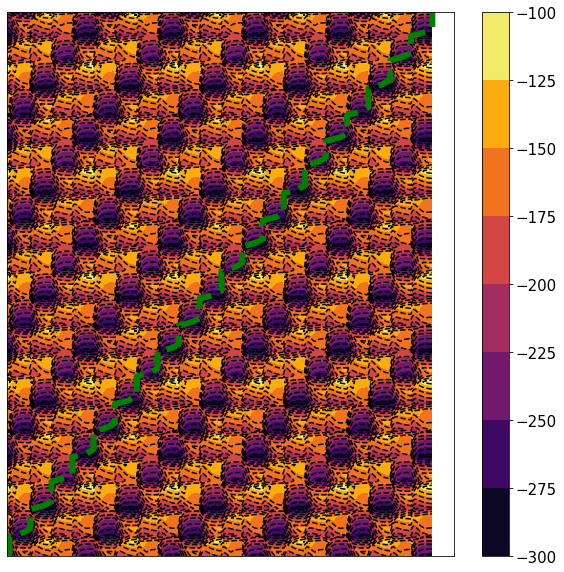

In [38]:
plt.figure(figsize=(10, 10))

# plt.imshow(np.clip((energy_surface - np.mean(energy_surface))/np.std(energy_surface), -4, 4), cmap="inferno")
c = plt.contourf(energy_surface_X, energy_surface_Y, energy_surface, cmap="inferno")
plt.contour(energy_surface_X, energy_surface_Y, energy_surface, colors=["black"], levels=10)
plt.plot(state_trajectory_state_v, state_trajectory_state_y, linewidth=6, color="green", linestyle="dashed")
# plt.plot(adiabatic_trajectory_v, adiabatic_trajectory_y, linewidth=6, color="blue", linestyle="dashed")

# plt.xlabel("V")
# plt.ylabel("Vd")
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False
    # labelsize=15,
) # labels along the bottom edge are off
# plt.ylim((0,800))
# plt.xlim((0,300))

plt.colorbar(c).ax.tick_params(labelsize=15)

plt.savefig("modelB_energy_surface.svg")

In [39]:
plt.figure(figsize=(20, 20))
plt.imshow(np.array([ phi @ xi.T @ var[0] for var in simulated ])[0:5000:50].T, cmap="inferno")

NameError: name 'phi' is not defined

<Figure size 1440x1440 with 0 Axes>

In [ ]:
np.linalg.eigh(mnet.jacobian(xi[:, 3]))